# Multi-label Classification and Regression

This notebook is based on fastai's **[Chapter 6](https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb)**.

Please read the corresponding part of chapter 6 before looking at this review. Next week we will cover the part of chapter 6 on regression!

*I suggest opening this notebook in Colab (where it can be easier to use GPU).*
*If you want to run it locally, set up the **deep-learning** environment in your terminal with `conda env create -f environment.yml` and activate it in your preferred IDE.*

In [1]:
### FOR COLAB USERS ###
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
# ### FOR LOCAL USERS ###
# import fastai
# print(fastai.__version__)

# ! pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.all import *

# Data
PASCAL Data

### Download Data

In [4]:
path = untar_data(URLs.PASCAL_2007)
Path.BASE_PATH = path
# (path).ls()

In [5]:
# read in labels csv
train_valid_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

# note: training set has column for whether or not the sample is part of the validation set
train_valid_df.head(10)

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
5,000017.jpg,person horse,False
6,000019.jpg,cat,True
7,000020.jpg,car,True
8,000021.jpg,dog person,True
9,000023.jpg,bicycle person,False


### Pull out the x and y data

In [6]:
def get_x(r):
  """
  get the x values (images)
  return the path of the image from the location in the csv
  """
  return path/'train'/r['fname']

def get_y(r):
  """
  get the y values (labels)
  return a list of all the labels in the labels column of the csv
  """
  return r['labels'].split(' ')

def splitter(df):
  """
  split the training data into train/validation sets by the is_valid column
  """
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train,valid

### Get the Data Block

In [7]:
dblock = DataBlock(
  blocks = (
    ImageBlock, # x data = images
    MultiCategoryBlock # y data = multiple labels per image
  ),
  splitter = splitter, # how to split into training/validation sets
  get_x = get_x, # where to get x data
  get_y = get_y, # where to get y data
  item_tfms = RandomResizedCrop(128, min_scale=0.35) # make sure the items are the same size
)

### Get train / valid datasets

In [8]:
# each collection returns tuples of x and y variables for each item
dsets = dblock.datasets(train_valid_df)

print(len(dsets))
len(dsets.train), len(dsets.valid)

5011


(2501, 2510)

In [9]:
# examine single sample
  # x = image
  # y = one-hot encoded values (0 if the label is not true, 1 if it is true)
sample_x, sample_y = dsets.train[2]

print(sample_x)
print(sample_y)

PILImage mode=RGB size=334x500
TensorMultiCategory([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


In [10]:
# how many label categories are there in y?
print(len(sample_y))

# what are they?
dsets.train.vocab

20


['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [11]:
# print which categories are 1 (instead of 0)
idxs = torch.where(dsets.train[2][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['bicycle','person']

### Create DataLoader to get mini-batches

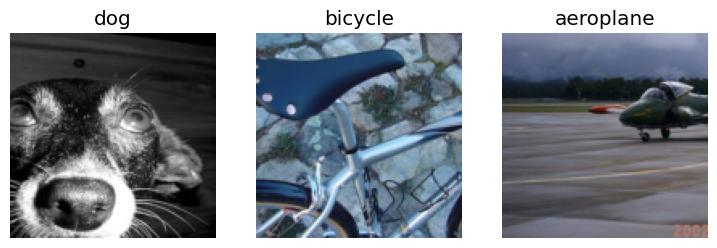

In [12]:
# data loaders collates the items from a dataset into a mini-batch
# each mini-batch is a tuple of a batch of x variables and a batch of y variables
dls = dblock.dataloaders(train_valid_df)

dls.show_batch(nrows=1, ncols=3)

# ResNet Model (transfer learning)

## Get Sample Data

In [13]:
# get a batch from the training set
x,y = to_cpu(dls.train.one_batch())

In [14]:
# get a single sample from the batch
sample_x = x[1]
sample_y = y[1]

print("x shape -- pixels:", tensor(sample_x).shape)
print("y shape -- categor(ies) the image belongs to:", sample_y.shape)
print("true y values:", sample_y)

x shape -- pixels: torch.Size([3, 128, 128])
y shape -- categor(ies) the image belongs to: torch.Size([20])
true y values: TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


In [15]:
# turn y and sample_y into an image tensor instead of TensorMultiCategory
# this shouldn't be necessary, but CoLab has been giving me type errors related to this
from fastai.torch_core import TensorImage, TensorMultiCategory

sample_y = TensorImage(sample_y).cuda() # cuda sends it to the gpu instead of cpu
y = TensorImage(y).cuda()

## Define Architecture

In [16]:
# create learner
learn = vision_learner(
  dls, # dataloaders object with data
  resnet18, # pre-trained model
  # opt_func: optimizer -- default (SGD)
  # loss_func: loss function  -- use default (Binary Cross Entropy)
  metrics = accuracy_multi # human metrics -- multi-class accuracy (with default threshold of 0.5)
)

In [17]:
# fine tune
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.993602,0.745947,0.573466,00:06
1,0.870161,0.580790,0.711275,00:08
2,0.643998,0.218336,0.944343,00:07
3,0.390761,0.142661,0.949881,00:06


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.153885,0.125565,0.954363,00:06
1,0.137661,0.121989,0.956056,00:06
2,0.121119,0.119288,0.956355,00:06


## Get Activations (Y Preds)

In [18]:
# get activations for the first batch of 64 images (x)
# note -- if doing this with the whole learner, use `learn.get_preds` instead
x = x.to(device='cuda')
activations = learn.model(x)
print(activations.shape)

torch.Size([64, 20])


In [19]:
# get activations for the single image sample
  # these are the probabilities the image belongs to each of the y categories
  # there will be as many activations as there are y categories (here, 20 categories)
sample_activ = activations[1]

print("activations shape:", sample_activ.shape)
print("activation values:", sample_activ)

activations shape: torch.Size([20])
activation values: TensorImage([-2.9628, -4.7759, -2.4882, -2.7240, -1.3156, -4.6241, -3.1990, -4.5378, -2.6324, -5.0870, -2.5971, -4.0648, -4.9869, -4.3883, -0.6917, -3.2130, -3.1025, -3.6606, -4.7267, -3.7068],
            device='cuda:0', grad_fn=<AliasBackward0>)


## Get Loss (Binary Cross-Entropy)
- We can't use Cross-Entropy / Softmax because that only works on one y label per image
- Instead, we use binary cross entropy, which compares each activation to its corresponding target label

### Get the loss for a single sample

#### Smooth each activation (y preds) from 0-1 with the sigmoid function

In [20]:
smoothed_activ = sample_activ.sigmoid()

print(smoothed_activ.shape)
smoothed_activ[0:3]

torch.Size([20])


TensorImage([0.0491, 0.0084, 0.0767], device='cuda:0', grad_fn=<AliasBackward0>)

#### Measure how distant each (smoothed) activation is from the true target label (y value)
- If the true label is a 1, what is the distance between the prediction and 1
- If the true label is a 0, what is the distance between the prediction and 0

In [21]:
dist_from_target = torch.where(
    sample_y == 1,
    smoothed_activ,
    (1 - smoothed_activ)
)

print(dist_from_target.shape)
dist_from_target[0:3]

torch.Size([20])


TensorImage([0.9509, 0.9916, 0.9233], device='cuda:0', grad_fn=<AliasBackward0>)

#### Get the loss for each category
Take the negative log of these distances

In [22]:
loss_all_target_classes = -dist_from_target.log()

print(loss_all_target_classes.shape)
loss_all_target_classes[0:3]

torch.Size([20])


TensorImage([0.0504, 0.0084, 0.0798], device='cuda:0', grad_fn=<AliasBackward0>)

#### Get the mean of the losses across all categories

In [23]:
mean_loss = loss_all_target_classes.mean()
print(mean_loss)

TensorImage(0.2278, device='cuda:0', grad_fn=<AliasBackward0>)


#### Do all of this as a function

In [24]:
def binary_cross_entropy(activtations, targets):
  """
  Goal: compare each activation (y pred) to each target value
  1. smooth the activations from 0-1 with the sigmoid function
  2. measure how distant each activation is from 1 if the true label is a 1
  and how distant it is from 0 if the true label is a 0,
  3. take the negative log of these results
  4. return the mean of all the results
  """
  inputs = activtations.sigmoid()
  loss_value = -torch.where(
    targets==1,
    inputs,
    1-inputs
  ).log().mean()

  return loss_value

#### Or, use PyTorch

In [25]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(sample_activ, sample_y)
loss

TensorImage(0.2278, device='cuda:0', grad_fn=<AliasBackward0>)

Annoying Pytorch conventions
- `F.binary_cross_entropy` and its module equivalent `nn.BCELoss` calculate cross-entropy on a one-hot-encoded target, but do not include the initial sigmoid.
- Normally for one-hot-encoded targets you'll want `F.binary_cross_entropy_with_logits` (or `nn.BCEWithLogitsLoss`), which do both sigmoid and binary cross-entropy in a single function, as in the preceding example.
- The equivalent for single-label datasets (like MNIST or the Pet dataset), where the target is encoded as a single integer, is `F.nll_loss` or `nn.NLLLoss` for the version without the initial softmax, and `F.cross_entropy` or `nn.CrossEntropyLoss` for the version with the initial softmax.

#### Summary

In [26]:
# one row for each of the y target classes
# to send to numpy, it needs to be on the cpu instead of gpu, which is where the .cpu() comes in
df = pd.DataFrame()
df['label'] = dsets.train.vocab
df['true_y'] = sample_y.cpu().int()
df['raw_activ'] = sample_activ.cpu().detach().numpy().round(2)
df['smoothed_activ'] = smoothed_activ.cpu().detach().numpy().round(2)
df['dist_from_true_y'] = dist_from_target.cpu().detach().numpy().round(2)
df['binary_cross_entropy_loss'] = loss_all_target_classes.cpu().detach().numpy().round(2)
df

,label,true_y,raw_activ,smoothed_activ,dist_from_true_y,binary_cross_entropy_loss
0,aeroplane,0,-2.96,0.05,0.95,0.05
1,bicycle,0,-4.78,0.01,0.99,0.01
2,bird,0,-2.49,0.08,0.92,0.08
3,boat,0,-2.72,0.06,0.94,0.06
4,bottle,0,-1.32,0.21,0.79,0.24
5,bus,0,-4.62,0.01,0.99,0.01
6,car,0,-3.20,0.04,0.96,0.04
7,cat,0,-4.54,0.01,0.99,0.01
8,chair,1,-2.63,0.07,0.07,2.70
9,cow,0,-5.09,0.01,0.99,0.01


### Get the loss for a batch of samples

In [27]:
# get activations (y preds)
# note -- if doing this with the whole learner, use `learn.get_preds` instead
activations = learn.model(x)
print(activations.shape)

torch.Size([64, 20])


In [28]:
# get loss (binary cross-entropy)
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activations, y)
loss

TensorImage(0.1840, device='cuda:0', grad_fn=<AliasBackward0>)

## Get Metrics (Accuracy)

### Accuracy for a single sample

In [29]:
# true y values
print("true y classes:\n", sample_y)

true y classes:
 TensorImage([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')


In [30]:
# for each of the y categories, what do we predict -- 0 or 1?
# use threshold value to decide
threshold_val = 0.5
pred_classes = (smoothed_activ > threshold_val)
print("predicted y classes:\n", pred_classes)

predicted y classes:
 TensorImage([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], device='cuda:0')


In [31]:
# decide if our predictions for each y category is correct
pred_classes_correct = pred_classes == sample_y.cuda().bool()
print("are the predicted classes correct:\n", pred_classes_correct)

are the predicted classes correct:
 TensorImage([ True,  True,  True,  True,  True,  True,  True,  True, False,  True,  True,  True,  True,  True, False,  True,  True,  True,  True,  True], device='cuda:0')


In [32]:
# take the mean (proportion of times the correct classes was predicted)
overall_acc = pred_classes_correct.float().mean()
print("overall accuracy mean:\n", overall_acc)

overall accuracy mean:
 TensorImage(0.9000, device='cuda:0')


### Use a function to compute accuracy over batch

In [33]:
def accuracy_multi(activations, targets, thresh=0.5, sigmoid=True):
  """
  Process: for each y category, predict whether the value is 0 or 1; compare to true y values
  Inputs: activations (smoothed or raw); targets (the true y values / labels)
  Threshold: default is 0.5
  Returns: average accuracy across all y categories
  """

  # do we need to smooth the activations?
    # if sigmoid=True, take the sigmoid of the (raw) activations
    # if sigmoid=False, do not take the sigmoid of the (already smoothed) activations
  if sigmoid:
    activations = activations.sigmoid()

  # for each y category, predict whether the y is 0 or 1 (using the smoothed activations)
    # if the (smoothed) activations are above the threshold, return a 1
    # if the (smoothed) activations are lower than the threshold, return a 0
  # are these predictions correct? -- aka do they match the true y target labels?
  acc = ((activations > thresh) == targets.bool())

  # take the mean of these predictions
  return acc.float().mean()

In [34]:
# get accuracy for a single sample -- using function we wrote
# note: using smoothed activations, so set sigmoid=False

threshold_val = 0.5
acc = accuracy_multi(smoothed_activ, sample_y, thresh=threshold_val, sigmoid=False)
print(acc)

TensorImage(0.9000, device='cuda:0')


In [35]:
# get accuracy for the batch
# note: using raw activations, so set sigmoid=True

threshold_val = 0.5
acc = accuracy_multi(activations, y, thresh=threshold_val, sigmoid=True)
acc

TensorImage(0.9375, device='cuda:0')

In [36]:
# get accuracy for the batch with a different threshold
threshold_val = 0.2
acc = accuracy_multi(activations, y, thresh=threshold_val, sigmoid=True)
print(acc)

TensorImage(0.9281, device='cuda:0')


In [37]:
# note -- the above is equivalent to:
acc_func = partial(accuracy_multi, thresh=0.2)
acc2 = acc_func(activations, y)
print(acc2)

TensorImage(0.9281, device='cuda:0')


## Using learner to do all of this on the validation set

In [38]:
# recall learner from above
learn = vision_learner(
  dls,
  resnet18,
  metrics = accuracy_multi # multi-class accuracy (with default threshold of 0.5)
)

# now fine-tune
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.996215,0.748442,0.565478,00:07
1,0.875623,0.586637,0.707590,00:08
2,0.642793,0.220640,0.942172,00:08
3,0.392060,0.145394,0.949402,00:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.155086,0.132381,0.951753,00:07
1,0.138061,0.122470,0.956554,00:07
2,0.122106,0.119319,0.957112,00:06


In [39]:
# get (smoothed) activations
# by default, the learn.get_preds() function smooths the activations for us
smoothed_activ, targets = learn.get_preds()
print(smoothed_activ.shape, targets.shape)

torch.Size([2510, 20]) torch.Size([2510, 20])


In [40]:
# get validation loss and (human) metrics for the validation set
learn.validate()

(#2) [0.11931869387626648,0.9571115970611572]

In [41]:
# use learner to get loss and metric (multi-category accuracy)
# for a different threshold
learn.metrics = partial(accuracy_multi, thresh=0.2)
learn.validate()

(#2) [0.11931869387626648,0.9444423317909241]

In [42]:
# this is a faster way to get the metric than the code above
accuracy_multi(smoothed_activ, targets, thresh=0.2, sigmoid=False)

tensor(0.9444)

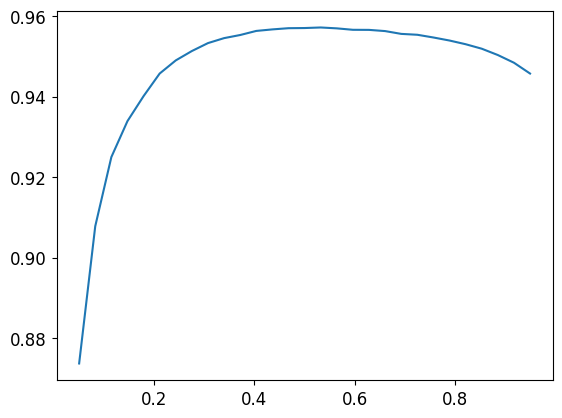

In [43]:
# plot accuracy by different thresholds
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(smoothed_activ, targets, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

# Regression

## Data
Biwi Kinect Head Pose dataset

### Download the data

In [44]:
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path
path.ls().sorted()

# see structure of path
(path/'01').ls().sorted() # see one directory

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [45]:
# get the image files
img_files = get_image_files(path)

In [46]:
# convert the filename to its associated pose text file
def img2pose(x):
  return Path(f'{str(x)[:-7]}pose.txt')

(480, 640)


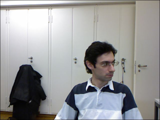

In [47]:
# get single sample
img2pose(img_files[0])

im = PILImage.create(img_files[0])
print(im.shape)
im.to_thumb(160)

In [48]:
# extract the center point of the head (don't focus on details)
# returns coordinates of where the head is in space
def get_ctr(f):
  cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

In [49]:
# get the y values from the sample image
get_ctr(img_files[0])

tensor([435.4011, 261.5263])

### Create Data Block
*Note: No libraries other than Fastai automatically and correctly apply data augmentation to coordinates. So, if you're working with another library, you may need to disable data augmentation for these kinds of problems.*

In [50]:
biwi = DataBlock(
  blocks=(
    ImageBlock, # input: image stuff
    PointBlock # outpoint: point block (means that the labels are coordinates)
  ),
  get_items=get_image_files, # not sure why this isn't get x
  get_y=get_ctr, # how to get the labels (see the function above)
  splitter=FuncSplitter(lambda o: o.parent.name=='13'), # validation set is only for person 13, training set is everyone else
  batch_tfms=aug_transforms(size=(240,320)), # augment (next week has more details)
)

### Get the Dataloaders

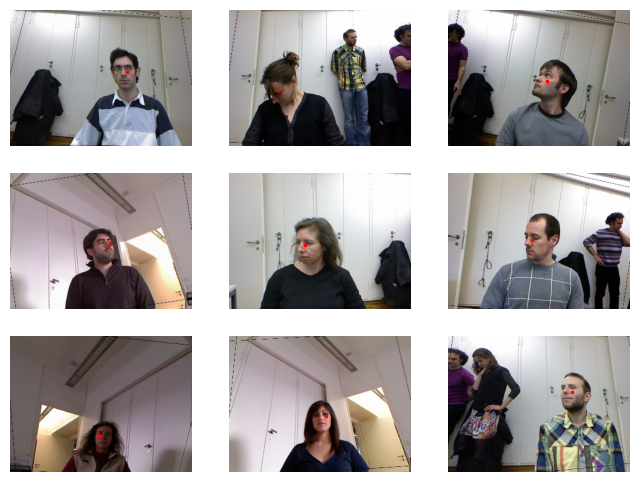

In [51]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

### Get Batch

In [52]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

### Get single sample

In [53]:
# x = pixels, y = coordinates
x_sample = xb[0]
y_sample = yb[0]

print(x_sample.shape)
print(y_sample.shape)
print(y_sample)

torch.Size([3, 240, 320])
torch.Size([1, 2])
TensorPoint([[0.2612, 0.2160]], device='cuda:0')


## Pre-trained ResNet Model

### Define Model Architecture

In [54]:
# create learner
learn = vision_learner(
  dls, # dataloaders object with data
  resnet18, # pre-trained model
  # opt_func: optimizer -- default (SGD)
  # loss_func: loss function  -- use default: FlattenedLoss of MSELoss()
  metrics = accuracy_multi, # metrics
  y_range = (-1,1) #  scale data between -1 and 1 (see below for details)
)

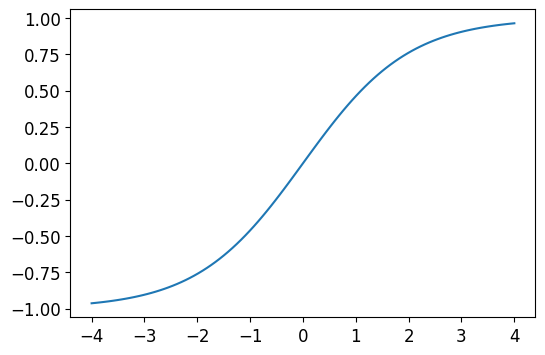

In [55]:
# fastai's internal function to scale y values between -1 and 1
  # useful for coordinates

def sigmoid_range(x, lo, hi):
  return torch.sigmoid(x) * (hi-lo) + lo

plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

### Loss (Mean Squared Error loss)

When coordinates are used as the dependent variable, most of the time we're likely to be trying to predict something as close as possible -- this is what MSELoss does

In [56]:
# this is the default value for the loss function based on the type of data we input
dls.loss_func

FlattenedLoss of MSELoss()

### Metrics
- mean squared error loss
- or square root of MSE loss

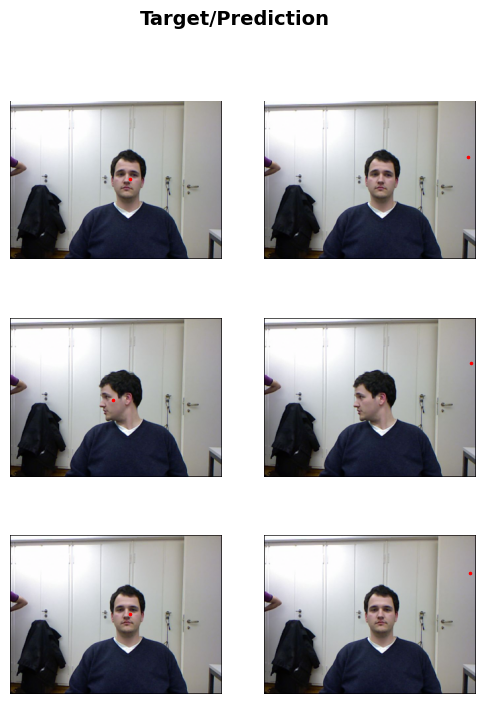

In [57]:
# evaluate
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

### Optimize

SuggestedLRs(valley=0.001737800776027143)

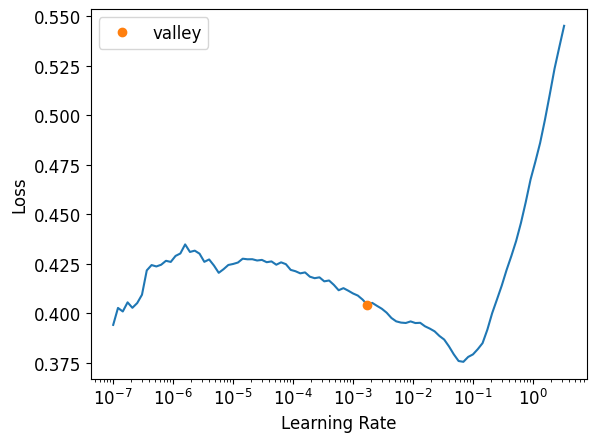

In [58]:
# find the best learning rate
learn.lr_find()

### Fine-tune

In [59]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.049563,0.049316,0.542268,00:34


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.008010,0.005468,0.714433,00:39
1,0.003014,0.000265,0.780412,00:39
2,0.001493,0.000083,0.714433,00:39


### See results

In [60]:
# loss (see above) is about 0.0001
# this corresponds to an average coordinate prediction error of:
math.sqrt(0.0001)

0.01

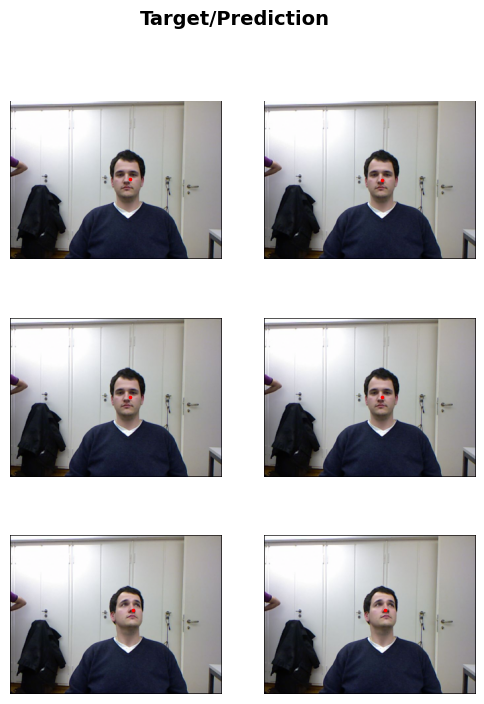

In [61]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))